## Import libraries

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support 
# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from manipulate_MNIST import *
from Simple_CNN import *

## Define dict for hyperparameters for multiple models

In [2]:
# hyperparameters for the model
hidden_neurons = 128
drop_rate = 0.5
batch_size_train = 128
learning_rate = 0.001
epochs = 3

# parameters for the attack
mal_percentage = 0.5
target_honest = 3
target_malicious = 8

# Honest model 1
honest1_params = {'name': "Honest 1", 'hidden_neurons': 128, 'drop_rate': 0.5, 'batch_size_train': 128, 'learning_rate': 0.001, 'epochs': 3, 'dataset_precentage': 0.9, 'mal_percentage': 0, 'target_honest': 0, 'target_malicious': 0}
# Honest model 2
honest2_params = {'name': "Honest 2", 'hidden_neurons': 64, 'drop_rate': 0.3, 'batch_size_train': 64, 'learning_rate': 0.01, 'epochs': 4, 'dataset_precentage': 0.8, 'mal_percentage': 0, 'target_honest': 0, 'target_malicious': 0}
# # Honest model 3
# honest3_params = {'name': "Honest 3", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.0001, 'epochs': 5, 'dataset_precentage': 0.8, 'mal_percentage': 0, 'target_honest': 0, 'target_malicious': 0}

# # Malicious_model 1
# mal1_params = {'name': "Malicious 1", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.0001, 'epochs': 5, 'dataset_precentage': 0.8, 'mal_percentage': 0.1, 'target_honest': 0, 'target_malicious': 0}

# # Malicious_model 2
# mal2_params = {'name': "Malicious 2", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.0001, 'epochs': 5, 'dataset_precentage': 0.8, 'mal_percentage': 0.2, 'target_honest': 0, 'target_malicious': 0}

# # Malicious_model 3
# mal3_params = {'name': "Malicious 3", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.0001, 'epochs': 5, 'dataset_precentage': 0.8, 'mal_percentage': 0.3, 'target_honest': 0, 'target_malicious': 0}

# # Malicious_model 4
# mal3_params = {'name': "Malicious 4", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.0001, 'epochs': 5, 'dataset_precentage': 0.8, 'mal_percentage': 0.3, 'target_honest': 0, 'target_malicious': 0}

# models = [honest1_params, honest2_params, honest3_params, mal1_params, mal2_params, mal3_params]
models = [honest1_params, honest2_params]

In [3]:
# Define the training data pipeline
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# get the original dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [5]:
model_losses = {}
for model in models:
    # perform the label-flipping
    trainset = generate_malicious_dataset(trainset, model['mal_percentage'], model['target_honest'], model['target_malicious'])
    # load it to the trainloader for training
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)


    cnn = SimpleCNN(model['hidden_neurons'], model['drop_rate'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(cnn.parameters(), lr=model['learning_rate'], momentum=0.9)

    # Train the network
    loss = []
    for epoch in range(model['epochs']):  # loop over the dataset multiple times
        epoch_loss, precision, recall, f1_score = train_epoch(optimizer, cnn, trainloader, criterion)
        loss.append(epoch_loss)
        # print("Epoch: ", epoch, " loss: ", round(epoch_loss,4), " precision: ", round(precision, 4), " recall: ", round(recall, 4), " f1_score ", round(f1_score, 4))
        # loss.append(epoch_loss.item())
    model_losses[model['name']] = loss


for model_name in model_losses:
    plt.plot(model_losses[model_name], label=model_name)

plt.xlabel("Epochs", fontsize=15)
plt.ylabel("BCE Loss", fontsize=15)
plt.show()

100%|██████████| 1875/1875 [00:52<00:00, 35.69it/s]


NameError: name 'plt' is not defined

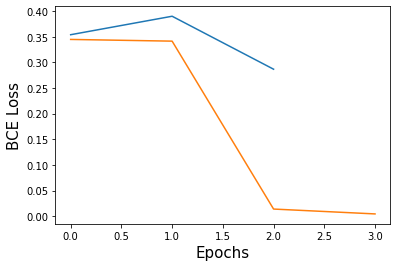

In [7]:
for model_name in model_losses:
    plt.plot(model_losses[model_name], label=model_name)

plt.xlabel("Epochs", fontsize=15)
plt.ylabel("BCE Loss", fontsize=15)
plt.show()

In [4]:
# Instantiate the network and the optimizer
model = SimpleCNN(hidden_neurons, drop_rate)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [5]:
# Train the network
loss = []
for epoch in range(epochs):  # loop over the dataset multiple times
    epoch_loss, precision, recall, f1_score = train_epoch(optimizer, model, trainloader, criterion)
    loss.append(epoch_loss)
    print("Epoch: ", epoch, " loss: ", round(epoch_loss,4), " precision: ", round(precision, 4), " recall: ", round(recall, 4), " f1_score ", round(f1_score, 4))
    loss.append(epoch_loss.item())

100%|██████████| 1875/1875 [01:03<00:00, 29.55it/s]Epoch:  2  loss:  0.0627  precision:  0.98  recall:  0.95  f1_score  0.9556



In [6]:
# Define the testing data pipeline
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

# Test the network and print the classification report
true_labels, pred_labels = predict_test(model, testloader)

print("Accuracy score: {}".format(round(accuracy_score(pred_labels,true_labels),3)))
print(classification_report(true_labels, pred_labels))

Accuracy score: 0.899
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.99      0.97      1135
           2       0.94      0.92      0.93      1032
           3       0.99      0.44      0.61      1010
           4       0.97      0.95      0.96       982
           5       0.92      0.96      0.94       892
           6       0.94      0.97      0.95       958
           7       0.95      0.93      0.94      1028
           8       0.60      0.94      0.73       974
           9       0.96      0.92      0.94      1009

    accuracy                           0.90     10000
   macro avg       0.92      0.90      0.89     10000
weighted avg       0.92      0.90      0.89     10000

